In [3]:
import pandas as pd
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 0. Core model + dataset (keep as-is)
# -------- Sliding-window dataset --------

class SlidingWindowDataset(Dataset):
    """
    Turn a time series (T, N) into input/target windows for forecasting.

    series: np.ndarray, shape (T,) or (T, N)
    input_len: length of history window
    pred_len:  length of prediction horizon
    """
    def __init__(self, series, input_len, pred_len, stride=1):
        if series.ndim == 1:
            series = series[:, None]  # (T,) -> (T,1)
        T, N = series.shape

        X_list, y_list = [], []
        for start in range(0, T - input_len - pred_len + 1, stride):
            end = start + input_len
            target_end = end + pred_len
            X_list.append(series[start:end])        # (input_len, N)
            y_list.append(series[end:target_end])   # (pred_len, N)

        self.X = torch.from_numpy(np.stack(X_list)).float()  # (B, L, N)
        self.y = torch.from_numpy(np.stack(y_list)).float()  # (B, H, N)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------- Positional encodings --------

class SinusoidalPositionalEncoding(nn.Module):
    """Standard Transformer sinusoidal positional encoding."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len]


class LearnablePositionalEncoding(nn.Module):
    """Learnable positional embeddings (one vector per index)."""
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pos_embed = nn.Embedding(max_len, d_model)

    def forward(self, x):
        b, seq_len, _ = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(b, -1)
        return x + self.pos_embed(positions)


# -------- Time-series Transformer --------

class TimeSeriesTransformer(nn.Module):
    """
    Simple encoder-only Transformer for time-series forecasting.

    - Supports sinusoidal or learnable positional encoding.
    - Predicts 'pred_len' future steps for each input series.
    """
    def __init__(
        self,
        input_dim=1,
        d_model=64,
        n_heads=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
        pred_len=1,
        pos_encoding_type="sin",  # "sin" or "learned"
        max_len=500,
    ):
        super().__init__()
        self.input_dim = input_dim
        self.pred_len = pred_len

        self.input_proj = nn.Linear(input_dim, d_model)

        if pos_encoding_type == "sin":
            self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len)
        elif pos_encoding_type == "learned":
            self.pos_encoding = LearnablePositionalEncoding(d_model, max_len)
        else:
            self.pos_encoding = None  # no PE (for ablation)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,   # (B, L, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, pred_len * input_dim)

    def forward(self, x):
        """
        x: (batch, seq_len, input_dim)
        returns: (batch, pred_len, input_dim)
        """
        h = self.input_proj(x)  # (B, L, d_model)

        if self.pos_encoding is not None:
            h = self.pos_encoding(h)

        h = self.encoder(h)     # (B, L, d_model)
        h_last = h[:, -1, :]    # (B, d_model)

        out = self.fc_out(h_last)                     # (B, pred_len * input_dim)
        out = out.view(-1, self.pred_len, self.input_dim)  # (B, pred_len, input_dim)
        return out


In [4]:
# 1. Single training wrapper (reuse everywhere)
def train_transformer_on_series(
    series,
    input_len=64,
    pred_len=1,
    batch_size=32,
    n_epochs=10,
    lr=1e-3,
    pos_encoding_type="sin",
    device=None,
):
    """
    Train a TimeSeriesTransformer on one time series.

    Returns
    -------
    model : nn.Module
    history : dict with keys 'train_loss', 'val_loss'
    test_loss : float (MSE on held-out test set)
    splits : (train_set, val_set, test_set)
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure shape (T, N)
    if isinstance(series, np.ndarray) and series.ndim == 1:
        series = series[:, None]
    elif torch.is_tensor(series) and series.ndim == 1:
        series = series.unsqueeze(-1).cpu().numpy()

    dataset = SlidingWindowDataset(series, input_len, pred_len)
    n_total = len(dataset)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    train_set, val_set, test_set = torch.utils.data.random_split(
        dataset,
        [n_train, n_val, n_test],
        generator=torch.Generator().manual_seed(42),
    )

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size)
    test_loader  = DataLoader(test_set,  batch_size=batch_size)

    model = TimeSeriesTransformer(
        input_dim=dataset.X.shape[-1],
        d_model=32,
        n_heads=4,
        num_layers=1,
        dim_feedforward=64,
        dropout=0.1,
        pred_len=pred_len,
        pos_encoding_type=pos_encoding_type,
        max_len=input_len,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(n_epochs):
        # --- train ---
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # --- validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(
            f"Epoch {epoch+1}/{n_epochs} "
            f"| train={train_loss:.4f} | val={val_loss:.4f}"
        )

    # --- test ---
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_loss += loss.item() * X_batch.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test MSE: {test_loss:.4f}")

    return model, history, test_loss, (train_set, val_set, test_set)


In [5]:
# 2. Synthetic data + stationarization in a structured way
from synthetic_data import (
    simulate_heavy_t_ar1,
    simulate_garch_11,
    simulate_regime_switching_mean,
    simulate_1_over_f_noise,
    simulate_season_trend_outliers,
)

# ---------- Stationarization helpers ----------

def zscore(X, axis=0, eps=1e-8):
    mean = X.mean(axis=axis, keepdims=True)
    std = X.std(axis=axis, keepdims=True)
    return (X - mean) / (std + eps)

def make_stationary_ar1(X):
    return zscore(X, axis=0)

def make_stationary_garch(r):
    return zscore(r, axis=0)

def make_stationary_regime(X):
    dX = np.diff(X, axis=0)
    return zscore(dX, axis=0)

def make_stationary_long_memory(X):
    return zscore(X, axis=0)

def make_stationary_season_trend(Y, season_period):
    Y1 = np.diff(Y, axis=0)          # (T-1, N)
    if Y1.shape[0] <= season_period:
        raise ValueError("Series too short for given season_period")
    Y2 = Y1[season_period:] - Y1[:-season_period]
    return zscore(Y2, axis=0)


In [6]:
T = 5000
n_epochs = 10

# (A) AR(1)
X_A = simulate_heavy_t_ar1(T, N=1, phi=0.5, df=3, seed=0)
series_A_raw  = X_A[:, 0]
X_A_stat      = make_stationary_ar1(X_A)
series_A_stat = X_A_stat[:, 0]

# (B) GARCH
r_B, sigma_B = simulate_garch_11(T, N=1, seed=0)
series_B_raw  = r_B[:, 0]
r_B_stat      = make_stationary_garch(r_B)
series_B_stat = r_B_stat[:, 0]

# (C) Regime-switching
X_C, S_C = simulate_regime_switching_mean(T, N=1, mu_A=0, mu_B=3, seed=0)
series_C_raw  = X_C[:, 0]
X_C_stat      = make_stationary_regime(X_C)
series_C_stat = X_C_stat[:, 0]

# (D) 1/f noise
X_D = simulate_1_over_f_noise(T, N=1, beta=0.8, seed=0)
series_D_raw  = X_D[:, 0]
X_D_stat      = make_stationary_long_memory(X_D)
series_D_stat = X_D_stat[:, 0]

# (E) Seasonal + trend + outliers
Y_E, out_idx = simulate_season_trend_outliers(
    T=2000,
    N=1,
    season_period=50,
    A=1.0,
    trend_slope=0.002,
    noise_sigma=0.2,
    n_outliers=8,
    outlier_magnitude=4.0,
    seed=0,
)
series_E_raw  = Y_E[:, 0]
Y_E_stat      = make_stationary_season_trend(Y_E, season_period=50)
series_E_stat = Y_E_stat[:, 0]

# ---------- Config dictionaries ----------

raw_series_dict = {
    "Heavy-tailed AR(1)": {
        "series": series_A_raw,
        "input_len": 64,
        "pos_encs": ["sin", "learned"],
    },
    "GARCH(1,1)": {
        "series": series_B_raw,
        "input_len": 64,
        "pos_encs": ["sin"],
    },
    "Regime-switching": {
        "series": series_C_raw,
        "input_len": 64,
        "pos_encs": ["sin"],
    },
    "1/f noise": {
        "series": series_D_raw,
        "input_len": 128,
        "pos_encs": ["sin"],
    },
    "Season+Trend+Outliers": {
        "series": series_E_raw,
        "input_len": 128,
        "pos_encs": ["sin"],
    },
}

stationary_series_dict = {
    "Heavy-tailed AR(1)": {
        "series": series_A_stat,
        "input_len": 64,
        "pos_encs": ["sin", "learned"],
    },
    "GARCH(1,1)": {
        "series": series_B_stat,
        "input_len": 64,
        "pos_encs": ["sin"],
    },
    "Regime-switching": {
        "series": series_C_stat,
        "input_len": 64,
        "pos_encs": ["sin"],
    },
    "1/f noise": {
        "series": series_D_stat,
        "input_len": 128,
        "pos_encs": ["sin"],
    },
    "Season+Trend+Outliers": {
        "series": series_E_stat,
        "input_len": 128,
        "pos_encs": ["sin"],
    },
}


In [ ]:
# 3. One unified experiment runner (raw & stationary, 1 & 10 steps)
def run_experiment_suite(
    series_dict,
    mode_label,
    horizons=(1, 10),
    n_epochs=10,
):
    """
    Run Transformer on all families, all pos_enc variants, and all horizons.
    
    series_dict[family] = {
        "series": np.array (T,),
        "input_len": int,
        "pos_encs": ["sin", "learned", ...],
    }
    """
    results = []
    histories = {}
    models = {}

    for family, cfg in series_dict.items():
        series = cfg["series"]
        input_len = cfg["input_len"]
        pos_encs = cfg["pos_encs"]

        for horizon in horizons:
            for pos_enc in pos_encs:
                print(f"\n=== {mode_label} | {family} | pos_enc={pos_enc} | horizon={horizon} ===")
                model, history, test_loss, splits = train_transformer_on_series(
                    series,
                    input_len=input_len,
                    pred_len=horizon,
                    n_epochs=n_epochs,
                    pos_encoding_type=pos_enc,
                )

                key = (mode_label, family, pos_enc, horizon)
                histories[key] = history
                models[key] = model

                results.append({
                    "mode": mode_label,         # "raw" or "stationary"
                    "family": family,
                    "pos_enc": pos_enc,
                    "horizon": horizon,
                    "test_MSE": float(test_loss),
                })

    results_df = pd.DataFrame(results)
    return results_df, histories, models


In [18]:
raw_models

{('raw',
  'Heavy-tailed AR(1)',
  'sin',
  1): TimeSeriesTransformer(
   (input_proj): Linear(in_features=1, out_features=32, bias=True)
   (pos_encoding): SinusoidalPositionalEncoding()
   (encoder): TransformerEncoder(
     (layers): ModuleList(
       (0): TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
         )
         (linear1): Linear(in_features=32, out_features=64, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=64, out_features=32, bias=True)
         (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (fc_out): Linear(in_features=32, out_features=1, bias=True)
 ),
 ('raw',
  'Heavy-tailed AR(1)',
  'le

In [8]:
raw_results_df, raw_histories, raw_models = run_experiment_suite(
    raw_series_dict,
    mode_label="raw",
    horizons=(1, 10),
    n_epochs=n_epochs,
)

stationary_results_df, stationary_histories, stationary_models = run_experiment_suite(
    stationary_series_dict,
    mode_label="stationary",
    horizons=(1, 10),
    n_epochs=n_epochs,
)

combined_df = pd.concat([raw_results_df, stationary_results_df], ignore_index=True)
combined_df



=== raw | Heavy-tailed AR(1) | pos_enc=sin | horizon=1 ===
Epoch 1/10 | train=3.1117 | val=2.8635
Epoch 2/10 | train=3.0366 | val=2.8127
Epoch 3/10 | train=3.0274 | val=2.8182
Epoch 4/10 | train=2.9763 | val=2.7993
Epoch 5/10 | train=2.9603 | val=2.7899
Epoch 6/10 | train=2.9577 | val=2.7815
Epoch 7/10 | train=2.9663 | val=2.8358
Epoch 8/10 | train=2.9427 | val=2.7662
Epoch 9/10 | train=2.9592 | val=2.7674
Epoch 10/10 | train=2.9529 | val=2.7777
Test MSE: 2.5417

=== raw | Heavy-tailed AR(1) | pos_enc=learned | horizon=1 ===
Epoch 1/10 | train=3.2422 | val=2.9194
Epoch 2/10 | train=3.0487 | val=2.8313
Epoch 3/10 | train=3.0292 | val=2.8009
Epoch 4/10 | train=2.9749 | val=2.8214
Epoch 5/10 | train=2.9471 | val=2.7791
Epoch 6/10 | train=2.9655 | val=2.8285
Epoch 7/10 | train=2.9619 | val=2.7878
Epoch 8/10 | train=2.9300 | val=2.7676
Epoch 9/10 | train=2.9500 | val=2.7852
Epoch 10/10 | train=2.9237 | val=2.7628
Test MSE: 2.5338

=== raw | Heavy-tailed AR(1) | pos_enc=sin | horizon=10 ===

,mode,family,pos_enc,horizon,test_MSE
0,raw,Heavy-tailed AR(1),sin,1,2.541681
1,raw,Heavy-tailed AR(1),learned,1,2.533823
2,raw,Heavy-tailed AR(1),sin,10,3.995196
3,raw,Heavy-tailed AR(1),learned,10,3.993605
4,raw,"GARCH(1,1)",sin,1,1.941802
5,raw,"GARCH(1,1)",sin,10,1.928998
6,raw,Regime-switching,sin,1,1.579822
7,raw,Regime-switching,sin,10,2.534024
8,raw,1/f noise,sin,1,0.636372
9,raw,1/f noise,sin,10,0.786401


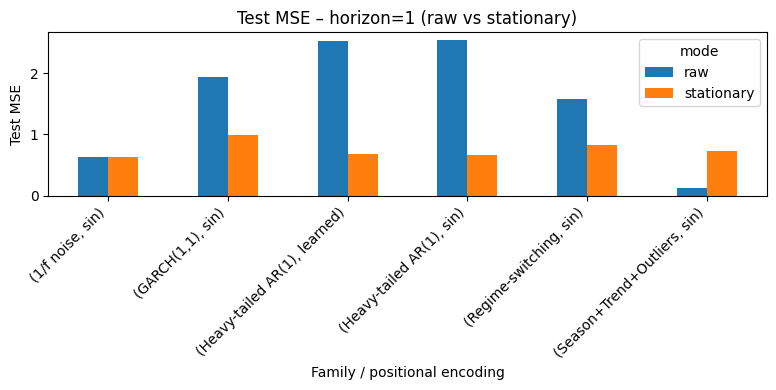

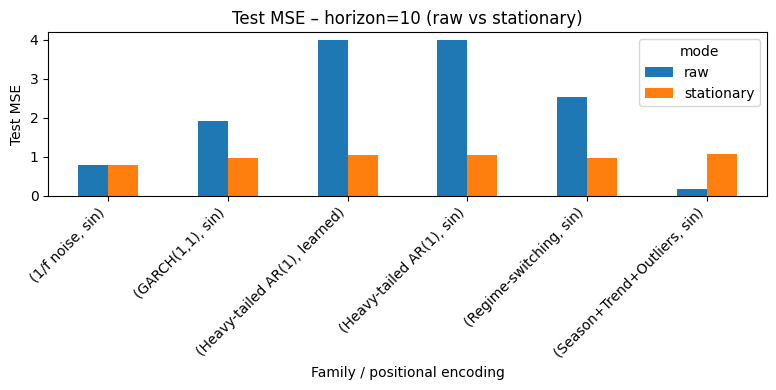

In [9]:
# 4. Visualizations
def plot_mse_raw_vs_stationary(combined_df):
    for horizon in sorted(combined_df["horizon"].unique()):
        df_h = combined_df[combined_df["horizon"] == horizon]

        plt.figure(figsize=(8, 4))
        # pivot: index=family+pos_enc, columns=mode, values=test_MSE
        df_pivot = df_h.pivot_table(
            index=["family", "pos_enc"],
            columns="mode",
            values="test_MSE",
        )

        df_pivot.plot(kind="bar", ax=plt.gca())
        plt.title(f"Test MSE – horizon={horizon} (raw vs stationary)")
        plt.ylabel("Test MSE")
        plt.xlabel("Family / positional encoding")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

plot_mse_raw_vs_stationary(combined_df)


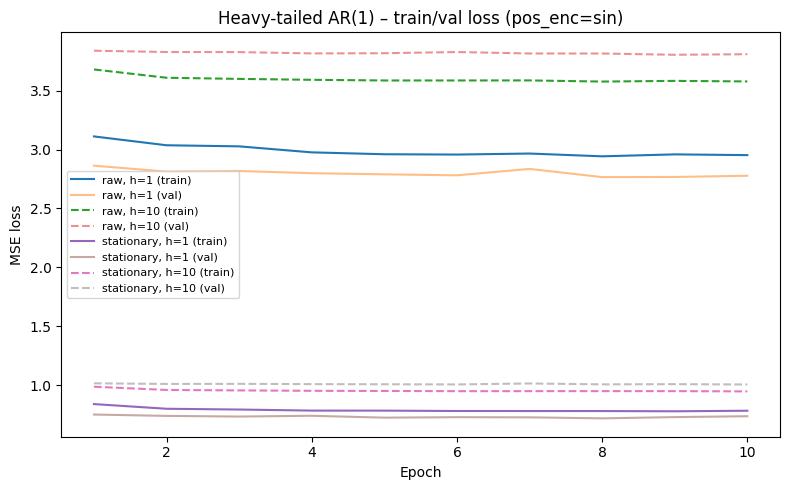

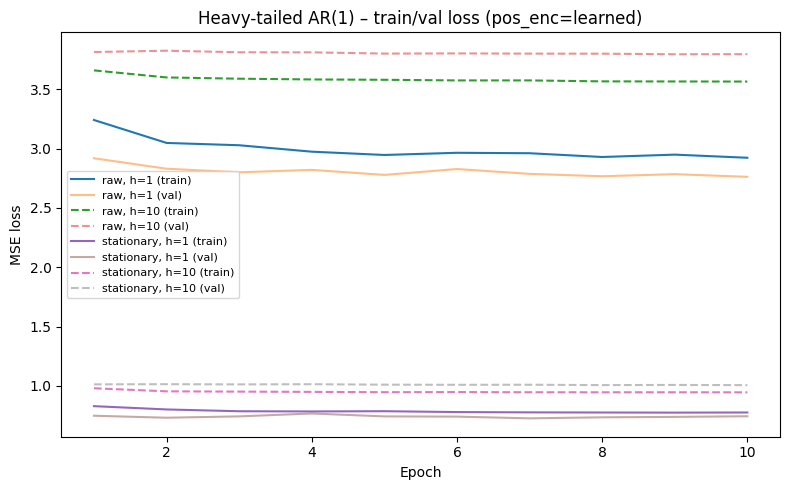

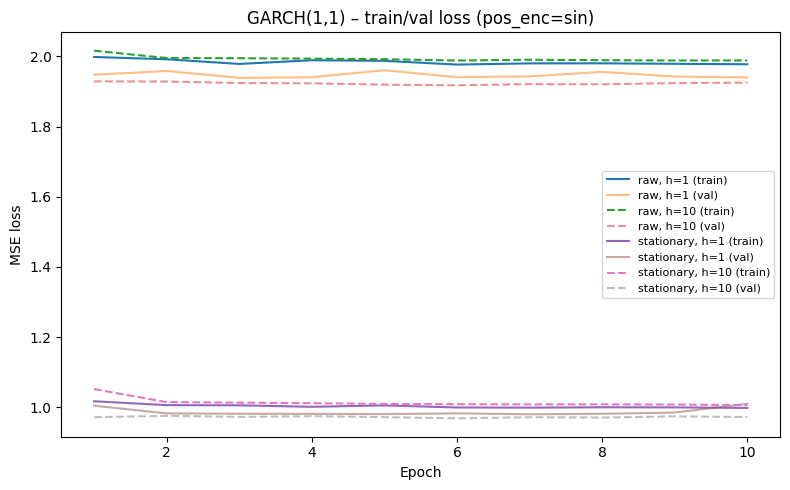

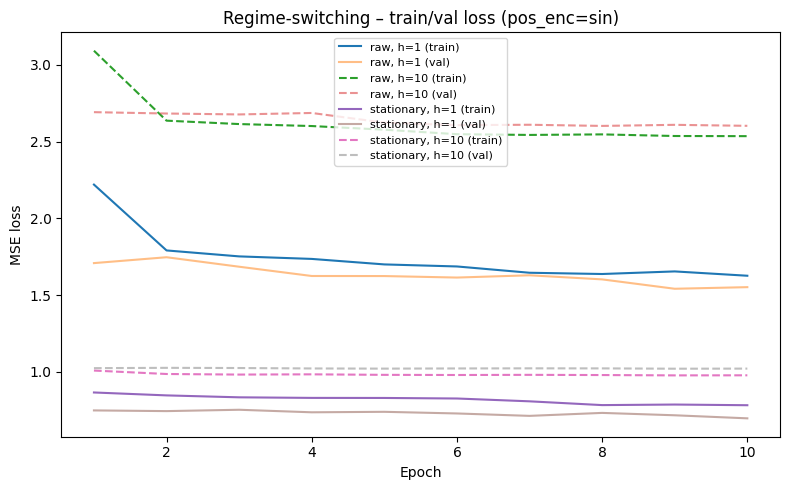

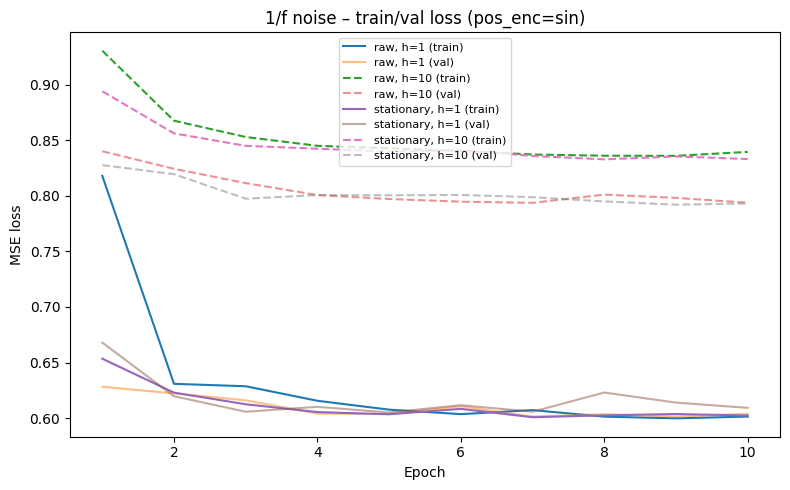

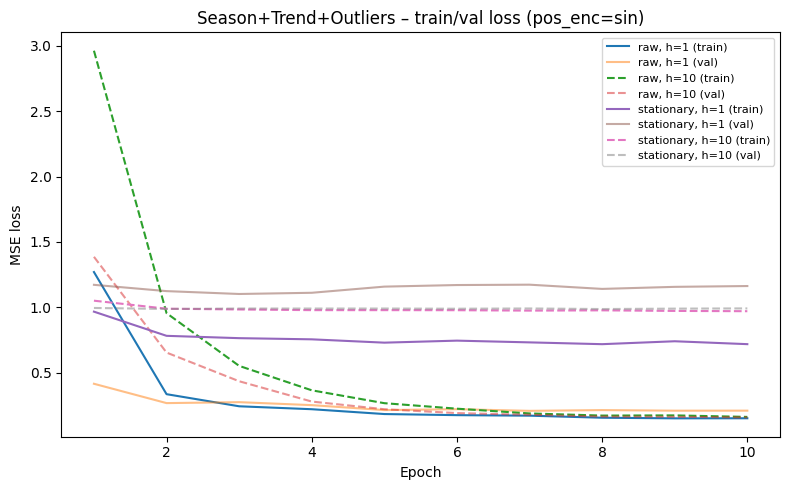

In [ ]:

def plot_family_histories_comparison(histories, family, pos_enc="sin"):
    """
    histories: dict keyed by (mode, family, pos_enc, horizon)
    """
    plt.figure(figsize=(8, 5))

    for mode in ["raw", "stationary"]:
        for horizon, style in zip([1, 10], ["-", "--"]):
            key = (mode, family, pos_enc, horizon)
            if key not in histories:
                continue
            hist = histories[key]
            epochs = range(1, len(hist["train_loss"]) + 1)
            label = f"{mode}, h={horizon} (train)"
            plt.plot(epochs, hist["train_loss"], linestyle=style, label=label)

            label_val = f"{mode}, h={horizon} (val)"
            plt.plot(epochs, hist["val_loss"], linestyle=style, alpha=0.5, label=label_val)

    plt.title(f"{family} – train/val loss (pos_enc={pos_enc})")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

all_histories = {**raw_histories, **stationary_histories}
families = [
    "Heavy-tailed AR(1)",
    "GARCH(1,1)",
    "Regime-switching",
    "1/f noise",
    "Season+Trend+Outliers",
]

# AR1: show sin and learned separately
plot_family_histories_comparison(all_histories, "Heavy-tailed AR(1)", pos_enc="sin")
plot_family_histories_comparison(all_histories, "Heavy-tailed AR(1)", pos_enc="learned")

# others: sin only
for fam in families[1:]:
    plot_family_histories_comparison(all_histories, fam, pos_enc="sin")


In [30]:
def rolling_multi_step_forecast(
    model,
    series,
    input_len,
    pred_len,
    input_dim_index=0,
    device=None,
    title="Rolling multi-step forecast",
    plot=True,
):
    """
    Returns multi-step forecasts for each sliding window:
    For window ending at time t, predicts [t+1 .. t+pred_len].

    Output: DataFrame with columns:
        t, horizon, actual, pred
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Ensure array shape (T, N)
    if torch.is_tensor(series):
        series = series.cpu().numpy()
    if series.ndim == 1:
        series = series[:, None]
    T, N = series.shape

    full_ds = SlidingWindowDataset(series, input_len=input_len, pred_len=pred_len, stride=1)
    full_loader = DataLoader(full_ds, batch_size=256, shuffle=False)

    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X_batch, y_batch in full_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)  # (B, pred_len, N)

            preds.append(y_pred[:, :, input_dim_index].cpu().numpy())
            trues.append(y_batch[:, :, input_dim_index].cpu().numpy())

    preds = np.concatenate(preds)   # (num_windows, pred_len)
    trues = np.concatenate(trues)

    # Build dataframe with columns: t, horizon, actual, pred
    records = []
    num_windows = preds.shape[0]

    # window ending at time t = input_len + i - 1
    for i in range(num_windows):
        window_end = input_len + i - 1
        for h in range(pred_len):
            t_pred = window_end + 1 + h  # forecasting t+1 ... t+pred_len
            if t_pred < T:
                records.append({
                    "t": t_pred,
                    "horizon": h + 1,
                    "actual": trues[i, h],
                    "pred": preds[i, h],
                })

    df = pd.DataFrame(records)

    if plot:
        plt.figure(figsize=(12, 5))
        plt.plot(range(T), series[:, input_dim_index], alpha=0.4, label="actual series")

        for h in range(1, pred_len + 1):
            df_h = df[df["horizon"] == h]
            plt.plot(df_h["t"], df_h["pred"], label=f"pred (h={h})")

        plt.title(title)
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return df


def make_rolling_metrics_row(
    mode,
    family,
    pos_enc,
    pred_len,
    df_forecast,
):
    """
    Compute rolling metrics (over all windows and horizons) from df_forecast.

    df_forecast columns: t, horizon, actual, pred
    """
    err = df_forecast["pred"] - df_forecast["actual"]
    roll_MSE = (err**2).mean()
    roll_MAE = err.abs().mean()

    row = {
        "mode": mode,               # "raw" or "stationary"
        "family": family,
        "pos_enc": pos_enc,
        "horizon": pred_len,        # same as pred_len (we only call this with that horizon)
        "roll_MSE": float(roll_MSE),
        "roll_MAE": float(roll_MAE),
    }

    # horizon-wise MAE
    for h in range(1, pred_len + 1):
        mask = df_forecast["horizon"] == h
        mae_h = (df_forecast.loc[mask, "pred"] - df_forecast.loc[mask, "actual"]).abs().mean()
        row[f"MAE_h{h}"] = float(mae_h)

    return row

def compute_rolling_metrics_for_mode(
    models,
    series_dict,
    mode_label,      # "raw" or "stationary"
    pred_len,        # 10 for your 10-step experiments
    device=None,
    plot=True,
):
    """
    For a given mode (raw / stationary) and horizon (e.g. 10-step),
    run rolling_multi_step_forecast for all families / pos_enc variants.

    Returns
    -------
    rolling_df : DataFrame with columns
        mode, family, pos_enc, horizon, roll_MSE, roll_MAE, MAE_h1..MAE_hK
    rolling_forecasts : dict keyed by (mode, family, pos_enc, horizon) -> df_forecast
    """
    rows = []
    rolling_forecasts = {}

    for family, cfg in series_dict.items():
        series = cfg["series"]
        input_len = cfg["input_len"]
        pos_encs = cfg["pos_encs"]

        for pos_enc in pos_encs:
            key = (mode_label, family, pos_enc, pred_len)
            if key not in models:
                continue

            model = models[key]
            title = f"{mode_label} – {family} – {pos_enc} – {pred_len}-step rolling"

            df_fore = rolling_multi_step_forecast(
                model=model,
                series=series,
                input_len=input_len,
                pred_len=pred_len,
                title=title,
                device=device,
                plot=plot,
            )

            row = make_rolling_metrics_row(
                mode=mode_label,
                family=family,
                pos_enc=pos_enc,
                pred_len=pred_len,
                df_forecast=df_fore,
            )

            rows.append(row)
            rolling_forecasts[key] = df_fore

    rolling_df = pd.DataFrame(rows)
    return rolling_df, rolling_forecasts



In [31]:
# After compute_rolling_metrics_for_mode(...)
all_rolling_forecasts = {**raw_histories, **stationary_histories}


def plot_family_rolling_predictions(
    all_forecasts,
    mode,
    family,
    pos_enc,
    horizon,
    max_horizons_to_show=3,
):
    key = (mode, family, pos_enc, horizon)
    if key not in all_forecasts:
        print("No forecast stored for", key)
        return

    df = all_forecasts[key]

    plt.figure(figsize=(10, 4))
    for h in range(1, min(max_horizons_to_show, horizon) + 1):
        df_h = df[df["horizon"] == h]
        plt.plot(df_h["t"], df_h["actual"], alpha=0.2, label="actual" if h == 1 else None)
        plt.plot(df_h["t"], df_h["pred"], label=f"pred (h={h})")

    plt.title(f"{mode} – {family} – {pos_enc} – {horizon}-step rolling")
    plt.xlabel("t")
    plt.ylabel("value")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example: AR(1), raw, sin PE
plot_family_rolling_predictions(
    all_rolling_forecasts,
    mode="raw",
    family="Heavy-tailed AR(1)",
    pos_enc="sin",
    horizon=10,
    max_horizons_to_show=3,
)


def make_rolling_metrics_row(
    mode,
    family,
    pos_enc,
    pred_len,
    df_forecast,
):
    """
    Compute rolling metrics (over all windows and horizons) from df_forecast.

    df_forecast columns: t, horizon, actual, pred
    """
    err = df_forecast["pred"] - df_forecast["actual"]
    roll_MSE = (err**2).mean()
    roll_MAE = err.abs().mean()

    row = {
        "mode": mode,               # "raw" or "stationary"
        "family": family,
        "pos_enc": pos_enc,
        "horizon": pred_len,
        "roll_MSE": float(roll_MSE),
        "roll_MAE": float(roll_MAE),
    }

    # horizon-wise MAE
    for h in range(1, pred_len + 1):
        mask = df_forecast["horizon"] == h
        mae_h = (df_forecast.loc[mask, "pred"] - df_forecast.loc[mask, "actual"]).abs().mean()
        row[f"MAE_h{h}"] = float(mae_h)

    return row

def compute_rolling_metrics_for_mode(
    models,
    series_dict,
    mode_label,      # "raw" or "stationary"
    pred_len,        # e.g., 10 for 10-step models
    device=None,
    plot=True,
):
    """
    For a given mode (raw / stationary) and horizon (e.g. 10-step),
    run rolling_multi_step_forecast for all families / pos_enc variants.

    Returns
    -------
    rolling_df : DataFrame with columns
        mode, family, pos_enc, horizon, roll_MSE, roll_MAE, MAE_h1..MAE_hK
    rolling_forecasts : dict keyed by (mode, family, pos_enc, horizon) -> df_forecast
    """
    rows = []
    rolling_forecasts = {}

    for family, cfg in series_dict.items():
        series = cfg["series"]
        input_len = cfg["input_len"]
        pos_encs = cfg["pos_encs"]

        for pos_enc in pos_encs:
            key = (mode_label, family, pos_enc, pred_len)
            if key not in models:
                continue

            model = models[key]
            title = f"{mode_label} – {family} – {pos_enc} – {pred_len}-step rolling"

            df_fore = rolling_multi_step_forecast(
                model=model,
                series=series,
                input_len=input_len,
                pred_len=pred_len,
                title=title,
                device=device,
                plot=plot,
            )

            row = make_rolling_metrics_row(
                mode=mode_label,
                family=family,
                pos_enc=pos_enc,
                pred_len=pred_len,
                df_forecast=df_fore,
            )

            rows.append(row)
            rolling_forecasts[key] = df_fore

    rolling_df = pd.DataFrame(rows)
    return rolling_df, rolling_forecasts

raw_results_df, raw_histories, raw_models = run_experiment_suite(...)
stationary_results_df, stationary_histories, stationary_models = run_experiment_suite(...)
combined_df = pd.concat([raw_results_df, stationary_results_df], ignore_index=True)


KeyError: 'horizon'

<Figure size 1000x400 with 0 Axes>

In [32]:
pred_len_for_rolling = 10  # horizon we want to evaluate

rolling_raw_df,  rolling_raw_forecasts  = compute_rolling_metrics_for_mode(
    models=raw_models,
    series_dict=raw_series_dict,
    mode_label="raw",
    pred_len=pred_len_for_rolling,
    plot=False,      # <--- turn off internal plots
)

rolling_stat_df, rolling_stat_forecasts = compute_rolling_metrics_for_mode(
    models=stationary_models,
    series_dict=stationary_series_dict,
    mode_label="stationary",
    pred_len=pred_len_for_rolling,
    plot=False,      # <--- same here
)


Plotting Heavy-tailed AR(1) ...


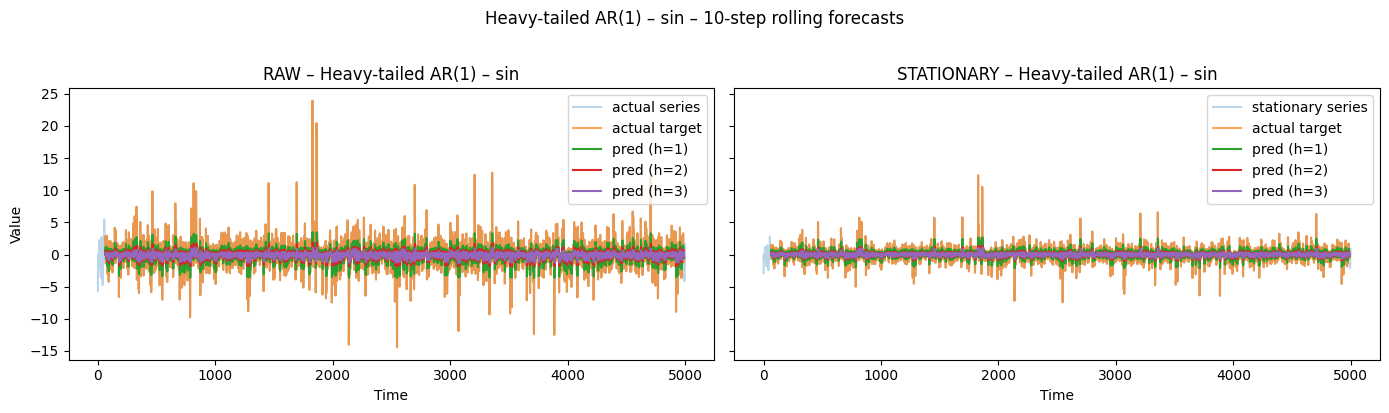

Plotting GARCH(1,1) ...


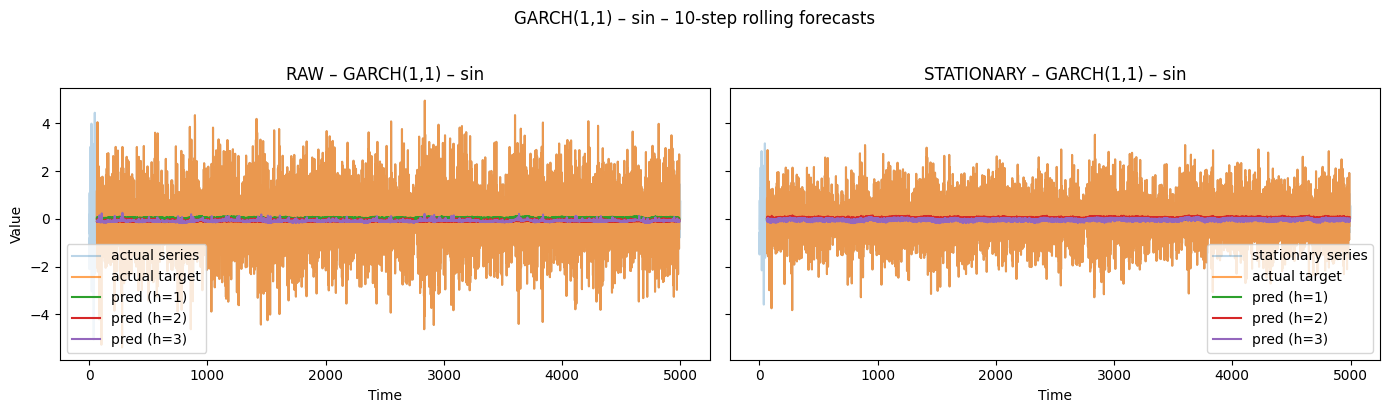

Plotting Regime-switching ...


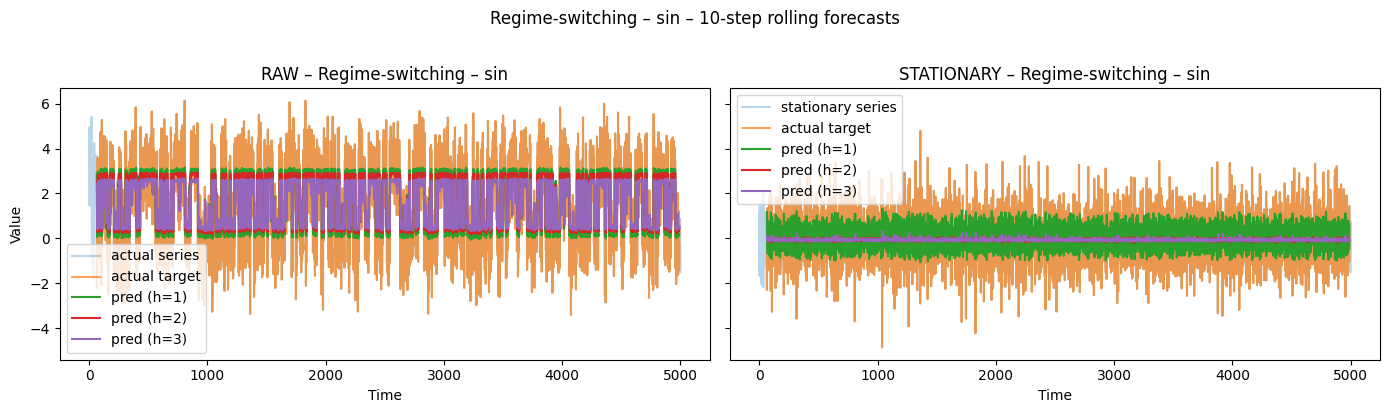

Plotting 1/f noise ...


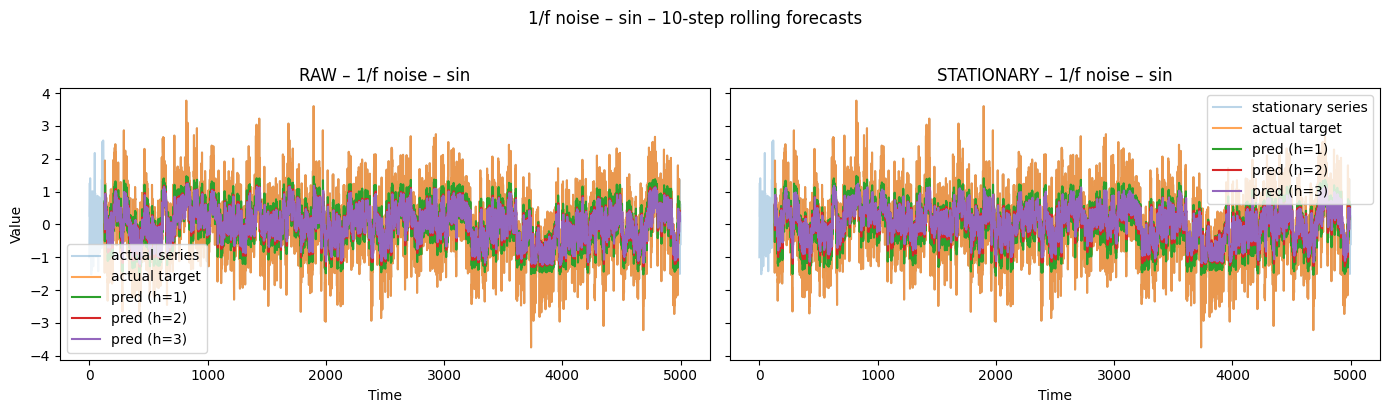

Plotting Season+Trend+Outliers ...


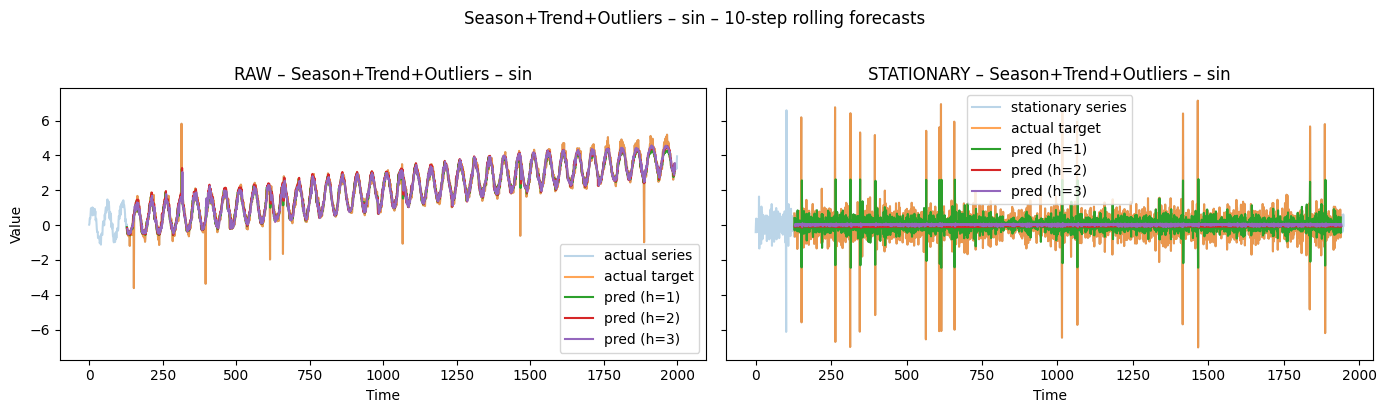

In [33]:
def plot_raw_vs_stationary_rolling(
    family,
    pos_enc="sin",
    horizon=10,
    max_horizons_to_show=3,
    raw_series_dict=raw_series_dict,
    stationary_series_dict=stationary_series_dict,
    rolling_raw_forecasts=rolling_raw_forecasts,
    rolling_stat_forecasts=rolling_stat_forecasts,
):
    """
    Side-by-side comparison of rolling multi-step forecasts:

        Left  subplot: raw series + preds
        Right subplot: stationary series + preds

    Uses forecast DataFrames stored in rolling_raw_forecasts / rolling_stat_forecasts,
    keyed by (mode, family, pos_enc, horizon).
    """

    key_raw  = ("raw",        family, pos_enc, horizon)
    key_stat = ("stationary", family, pos_enc, horizon)

    if key_raw not in rolling_raw_forecasts:
        print("No raw forecast stored for", key_raw)
        return
    if key_stat not in rolling_stat_forecasts:
        print("No stationary forecast stored for", key_stat)
        return

    df_raw  = rolling_raw_forecasts[key_raw]
    df_stat = rolling_stat_forecasts[key_stat]

    # underlying series
    series_raw  = raw_series_dict[family]["series"]
    series_stat = stationary_series_dict[family]["series"]

    if series_raw.ndim == 2:
        series_raw = series_raw[:, 0]
    if series_stat.ndim == 2:
        series_stat = series_stat[:, 0]

    T_raw  = len(series_raw)
    T_stat = len(series_stat)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    # ------------ RAW ------------
    ax = axes[0]
    ax.plot(np.arange(T_raw), series_raw, alpha=0.3, label="actual series")

    # actual targets (from horizon 1)
    df_r_h1 = df_raw[df_raw["horizon"] == 1]
    ax.plot(df_r_h1["t"], df_r_h1["actual"], alpha=0.7, label="actual target")

    for h in range(1, min(max_horizons_to_show, horizon) + 1):
        df_h = df_raw[df_raw["horizon"] == h]
        ax.plot(df_h["t"], df_h["pred"], label=f"pred (h={h})")

    ax.set_title(f"RAW – {family} – {pos_enc}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend()

    # --------- STATIONARY ---------
    ax = axes[1]
    ax.plot(np.arange(T_stat), series_stat, alpha=0.3, label="stationary series")

    df_s_h1 = df_stat[df_stat["horizon"] == 1]
    ax.plot(df_s_h1["t"], df_s_h1["actual"], alpha=0.7, label="actual target")

    for h in range(1, min(max_horizons_to_show, horizon) + 1):
        df_h = df_stat[df_stat["horizon"] == h]
        ax.plot(df_h["t"], df_h["pred"], label=f"pred (h={h})")

    ax.set_title(f"STATIONARY – {family} – {pos_enc}")
    ax.set_xlabel("Time")
    ax.legend()

    plt.suptitle(f"{family} – {pos_enc} – {horizon}-step rolling forecasts", y=1.02)
    plt.tight_layout()
    plt.show()

for fam in raw_series_dict.keys():
    print(f"Plotting {fam} ...")
    plot_raw_vs_stationary_rolling(
        family=fam,
        pos_enc="sin",
        horizon=10,
        max_horizons_to_show=3,
    )
